# SQLite Indexing Performance Demonstration

## Database Structure
- **users**: 100,000 users with demographic data
- **products**: 50,000 products with categories and pricing
- **orders**: 1,000,000 orders linking users and products

## Setup
First, make sure you've run the `create_synthetic_db.py` script to generate the database.


In [1]:
%pip install seaborn
%pip install matplotlib
%pip install pandas
%pip install sqlite3
%pip install time
%pip install os
%pip install typing

/Users/ekirimlioglu/Cursor/Rickg/DSE200-Day1/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.
/Users/ekirimlioglu/Cursor/Rickg/DSE200-Day1/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.
/Users/ekirimlioglu/Cursor/Rickg/DSE200-Day1/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.
/Users/ekirimlioglu/Cursor/Rickg/DSE200-Day1/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.
/Users/ekirimlioglu/Cursor/Rickg/DSE200-Day1/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.
/Users/ekirimlioglu/Cursor/Rickg/DSE200-Day1/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.
/Users/ekirimlioglu/Cursor/Rickg/DSE200-Day1/.venv/bin/python: No module named pip
Note: you may need to r

In [2]:
import sqlite3
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import os

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Database path
DB_PATH = 'synthetic_performance_test.db'

print(f"Looking for database: {DB_PATH}")
if os.path.exists(DB_PATH):
    print("✓ Database found!")
    # Get database size
    size_mb = os.path.getsize(DB_PATH) / (1024 * 1024)
    print(f"Database size: {size_mb:.2f} MB")
else:
    print("Database not found. Please run 'python create_synthetic_db.py' first.")


Looking for database: synthetic_performance_test.db
✓ Database found!
Database size: 130.25 MB


## Database Overview
Let's first examine the structure and size of our database.


In [3]:
def get_table_info(db_path: str) -> Dict[str, int]:
    """Get basic information about tables in the database."""
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Get table names
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
    tables = [row[0] for row in cursor.fetchall()]
    
    # Get row counts
    table_info = {}
    for table in tables:
        cursor.execute(f"SELECT COUNT(*) FROM {table}")
        count = cursor.fetchone()[0]
        table_info[table] = count
    
    conn.close()
    return table_info

def show_table_schemas(db_path: str):
    """Display the schema of all tables."""
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
    tables = [row[0] for row in cursor.fetchall()]
    
    for table in tables:
        print(f"\n=== {table.upper()} TABLE ===")
        cursor.execute(f"PRAGMA table_info({table})")
        columns = cursor.fetchall()
        for col in columns:
            print(f"{col[1]:<20} {col[2]:<15} {'PRIMARY KEY' if col[5] else ''}")
    
    conn.close()

# Show database overview
if os.path.exists(DB_PATH):
    table_info = get_table_info(DB_PATH)
    print("Table row counts:")
    for table, count in table_info.items():
        print(f"{table:<10}: {count:>10,} rows")
    
    show_table_schemas(DB_PATH)


Table row counts:
users     :    100,000 rows
products  :     50,000 rows
orders    :  1,000,000 rows

=== USERS TABLE ===
user_id              INTEGER         PRIMARY KEY
email                TEXT            
first_name           TEXT            
last_name            TEXT            
age                  INTEGER         
city                 TEXT            
country              TEXT            
registration_date    TEXT            
account_balance      REAL            
is_premium           BOOLEAN         

=== PRODUCTS TABLE ===
product_id           INTEGER         PRIMARY KEY
product_name         TEXT            
category             TEXT            
subcategory          TEXT            
price                REAL            
brand                TEXT            
description          TEXT            
created_date         TEXT            
stock_quantity       INTEGER         
rating               REAL            

=== ORDERS TABLE ===
order_id             INTEGER         PRIMARY KEY


## Performance Testing Framework

We'll create a framework to test queries both with and without indexes to demonstrate the performance difference.

In [7]:
def time_query(conn: sqlite3.Connection, query: str, params=None, runs: int = 5) -> Tuple[float, List]:
    """Time a query execution and return average time and results."""
    times = []
    results = None
    
    for _ in range(runs):
        start_time = time.time()
        cursor = conn.cursor()
        if params:
            cursor.execute(query, params)
        else:
            cursor.execute(query)
        results = cursor.fetchall()
        end_time = time.time()
        times.append(end_time - start_time)
        cursor.close()
    
    avg_time = sum(times) / len(times)
    return avg_time, results

def drop_all_indexes(conn: sqlite3.Connection):
    """Drop all non-primary key indexes from the database."""
    cursor = conn.cursor()
    
    # Get all indexes (excluding primary key indexes)
    cursor.execute("""
        SELECT name FROM sqlite_master 
        WHERE type = 'index' 
        AND name NOT LIKE 'sqlite_%'
    """)
    
    indexes = cursor.fetchall()
    
    for (index_name,) in indexes:
        print(f"Dropping index: {index_name}")
        cursor.execute(f"DROP INDEX IF EXISTS {index_name}")
    
    conn.commit()
    cursor.close()
    print(f"Dropped {len(indexes)} indexes")

def create_test_indexes(conn: sqlite3.Connection):
    """Create the indexes we want to test."""
    cursor = conn.cursor()
    
    indexes = [
        "CREATE INDEX IF NOT EXISTS idx_users_email ON users(email)",
        "CREATE INDEX IF NOT EXISTS idx_users_city ON users(city)",
        "CREATE INDEX IF NOT EXISTS idx_users_age ON users(age)",
        "CREATE INDEX IF NOT EXISTS idx_products_category ON products(category)",
        "CREATE INDEX IF NOT EXISTS idx_products_price ON products(price)",
        "CREATE INDEX IF NOT EXISTS idx_orders_user_id ON orders(user_id)",
        "CREATE INDEX IF NOT EXISTS idx_orders_product_id ON orders(product_id)",
        "CREATE INDEX IF NOT EXISTS idx_orders_date ON orders(order_date)",
        "CREATE INDEX IF NOT EXISTS idx_orders_status ON orders(order_status)",
        "CREATE INDEX IF NOT EXISTS idx_orders_amount ON orders(total_amount)",
        # Composite indexes
        "CREATE INDEX IF NOT EXISTS idx_orders_user_date ON orders(user_id, order_date)",
        "CREATE INDEX IF NOT EXISTS idx_products_category_price ON products(category, price)",
    ]
    
    for index_sql in indexes:
        index_name = index_sql.split()[5]  # Extract index name
        print(f"Creating index: {index_name}")
        start_time = time.time()
        cursor.execute(index_sql)
        end_time = time.time()
        print(f"  Created in {end_time - start_time:.3f} seconds")
    
    conn.commit()
    cursor.close()

def run_performance_test(db_path: str, test_queries: List[Dict]) -> pd.DataFrame:
    """Run performance tests with and without indexes."""
    results = []
    
    conn = sqlite3.connect(db_path)
    
    # Test without indexes
    print("=" * 50)
    print("TESTING WITHOUT INDEXES")
    print("=" * 50)
    
    drop_all_indexes(conn)
    
    for i, test in enumerate(test_queries, 1):
        print(f"\nTest {i}: {test['name']}")
        print(f"Query: {test['query'][:500]}{'...' if len(test['query']) > 500 else ''}")
        
        avg_time, result_set = time_query(conn, test['query'], test.get('params'))
        
        results.append({
            'test_name': test['name'],
            'query_type': test['type'],
            'indexed': False,
            'avg_time_seconds': avg_time,
            'result_count': len(result_set) if result_set else 0
        })
        
        print(f"Time: {avg_time:.4f} seconds, Results: {len(result_set) if result_set else 0}")
    
    # Test with indexes
    print("\n" + "=" * 50)
    print("TESTING WITH INDEXES")
    print("=" * 50)
    
    create_test_indexes(conn)
    
    for i, test in enumerate(test_queries, 1):
        print(f"\nTest {i}: {test['name']}")
        print(f"Query: {test['query'][:500]}{'...' if len(test['query']) > 500 else ''}")
        
        avg_time, result_set = time_query(conn, test['query'], test.get('params'))
        
        results.append({
            'test_name': test['name'],
            'query_type': test['type'],
            'indexed': True,
            'avg_time_seconds': avg_time,
            'result_count': len(result_set) if result_set else 0
        })
        
        print(f"Time: {avg_time:.4f} seconds, Results: {len(result_set) if result_set else 0}")
    
    conn.close()
    
    return pd.DataFrame(results)

## Test Queries

Let's define a comprehensive set of queries to test different indexing scenarios:
1. **Exact lookups** - Finding specific values
2. **Range queries** - Filtering by ranges  
3. **Joins** - Combining tables
4. **Aggregations** - Grouping and counting
5. **Sorting** - ORDER BY operations

In [17]:
# Define comprehensive test queries
test_queries = [
    # 1. EXACT LOOKUPS
    {
        'name': 'Find user by email',
        'type': 'exact_lookup',
        'query': "SELECT * FROM users WHERE email = 'john.doe@example.com'"
    },
    {
        'name': 'Find products by category',
        'type': 'exact_lookup', 
        'query': "SELECT * FROM products WHERE category = 'Electronics'"
    },
    {
        'name': 'Find orders by status',
        'type': 'exact_lookup',
        'query': "SELECT * FROM orders WHERE order_status = 'delivered'"
    },

    
    # 3. JOIN OPERATIONS
    {
        'name': 'Join users and orders',
        'type': 'join',
        'query': """
            SELECT u.first_name, u.last_name, o.order_date, o.total_amount
            FROM users u
            JOIN orders o ON u.user_id = o.user_id
            WHERE u.city = 'New York'
            LIMIT 1000
        """
    },
    {
        'name': 'Three-way join',
        'type': 'join',
        'query': """
            SELECT u.first_name, u.last_name, p.product_name, o.total_amount
            FROM users u
            JOIN orders o ON u.user_id = o.user_id
            JOIN products p ON o.product_id = p.product_id
            WHERE p.price > 500
            LIMIT 1000
        """
    },
    
    # 4. AGGREGATION QUERIES
    {
        'name': 'Count orders by status',
        'type': 'aggregation',
        'query': """
            SELECT order_status, COUNT(*) as count
            FROM orders 
            GROUP BY order_status
        """
    },
    {
        'name': 'Average order amount by user',
        'type': 'aggregation',
        'query': """
            SELECT user_id, AVG(total_amount) as avg_amount
            FROM orders 
            GROUP BY user_id
            HAVING COUNT(*) > 5
            LIMIT 1000
        """
    },
    
    
]

print(f"Defined {len(test_queries)} test queries:")
for i, query in enumerate(test_queries, 1):
    print(f"{i:2d}. [{query['type']:12}] {query['name']}")

Defined 7 test queries:
 1. [exact_lookup] Find user by email
 2. [exact_lookup] Find products by category
 3. [exact_lookup] Find orders by status
 4. [join        ] Join users and orders
 5. [join        ] Three-way join
 6. [aggregation ] Count orders by status
 7. [aggregation ] Average order amount by user


## Running the Performance Tests

Now let's run all our test queries and collect performance data!

In [18]:
# Run the comprehensive performance test
if os.path.exists(DB_PATH):
    # Run performance tests
    performance_results = run_performance_test(DB_PATH, test_queries)
    
    performance_results.groupby(['indexed', 'query_type'])['avg_time_seconds'].agg(['count', 'mean', 'std']).round(4)
    
else:
    print("Database not found! running create_synthetic_db.py")
    !python create_synthetic_db.py
    performance_results = run_performance_test(DB_PATH, test_queries)
    performance_results.groupby(['indexed', 'query_type'])['avg_time_seconds'].agg(['count', 'mean', 'std']).round(4)

TESTING WITHOUT INDEXES
Dropping index: idx_users_email
Dropping index: idx_users_city
Dropping index: idx_users_age
Dropping index: idx_products_category
Dropping index: idx_products_price
Dropping index: idx_orders_user_id
Dropping index: idx_orders_product_id
Dropping index: idx_orders_date
Dropping index: idx_orders_status
Dropping index: idx_orders_amount
Dropping index: idx_orders_user_date
Dropping index: idx_products_category_price
Dropped 12 indexes

Test 1: Find user by email
Query: SELECT * FROM users WHERE email = 'john.doe@example.com'
Time: 0.0071 seconds, Results: 0

Test 2: Find products by category
Query: SELECT * FROM products WHERE category = 'Electronics'
Time: 0.0147 seconds, Results: 6291

Test 3: Find orders by status
Query: SELECT * FROM orders WHERE order_status = 'delivered'
Time: 0.3198 seconds, Results: 166579

Test 4: Join users and orders
Query: 
            SELECT u.first_name, u.last_name, o.order_date, o.total_amount
            FROM users u
           

## Performance Analysis and Visualization

Let's create comprehensive visualizations to understand the impact of indexing on query performance.

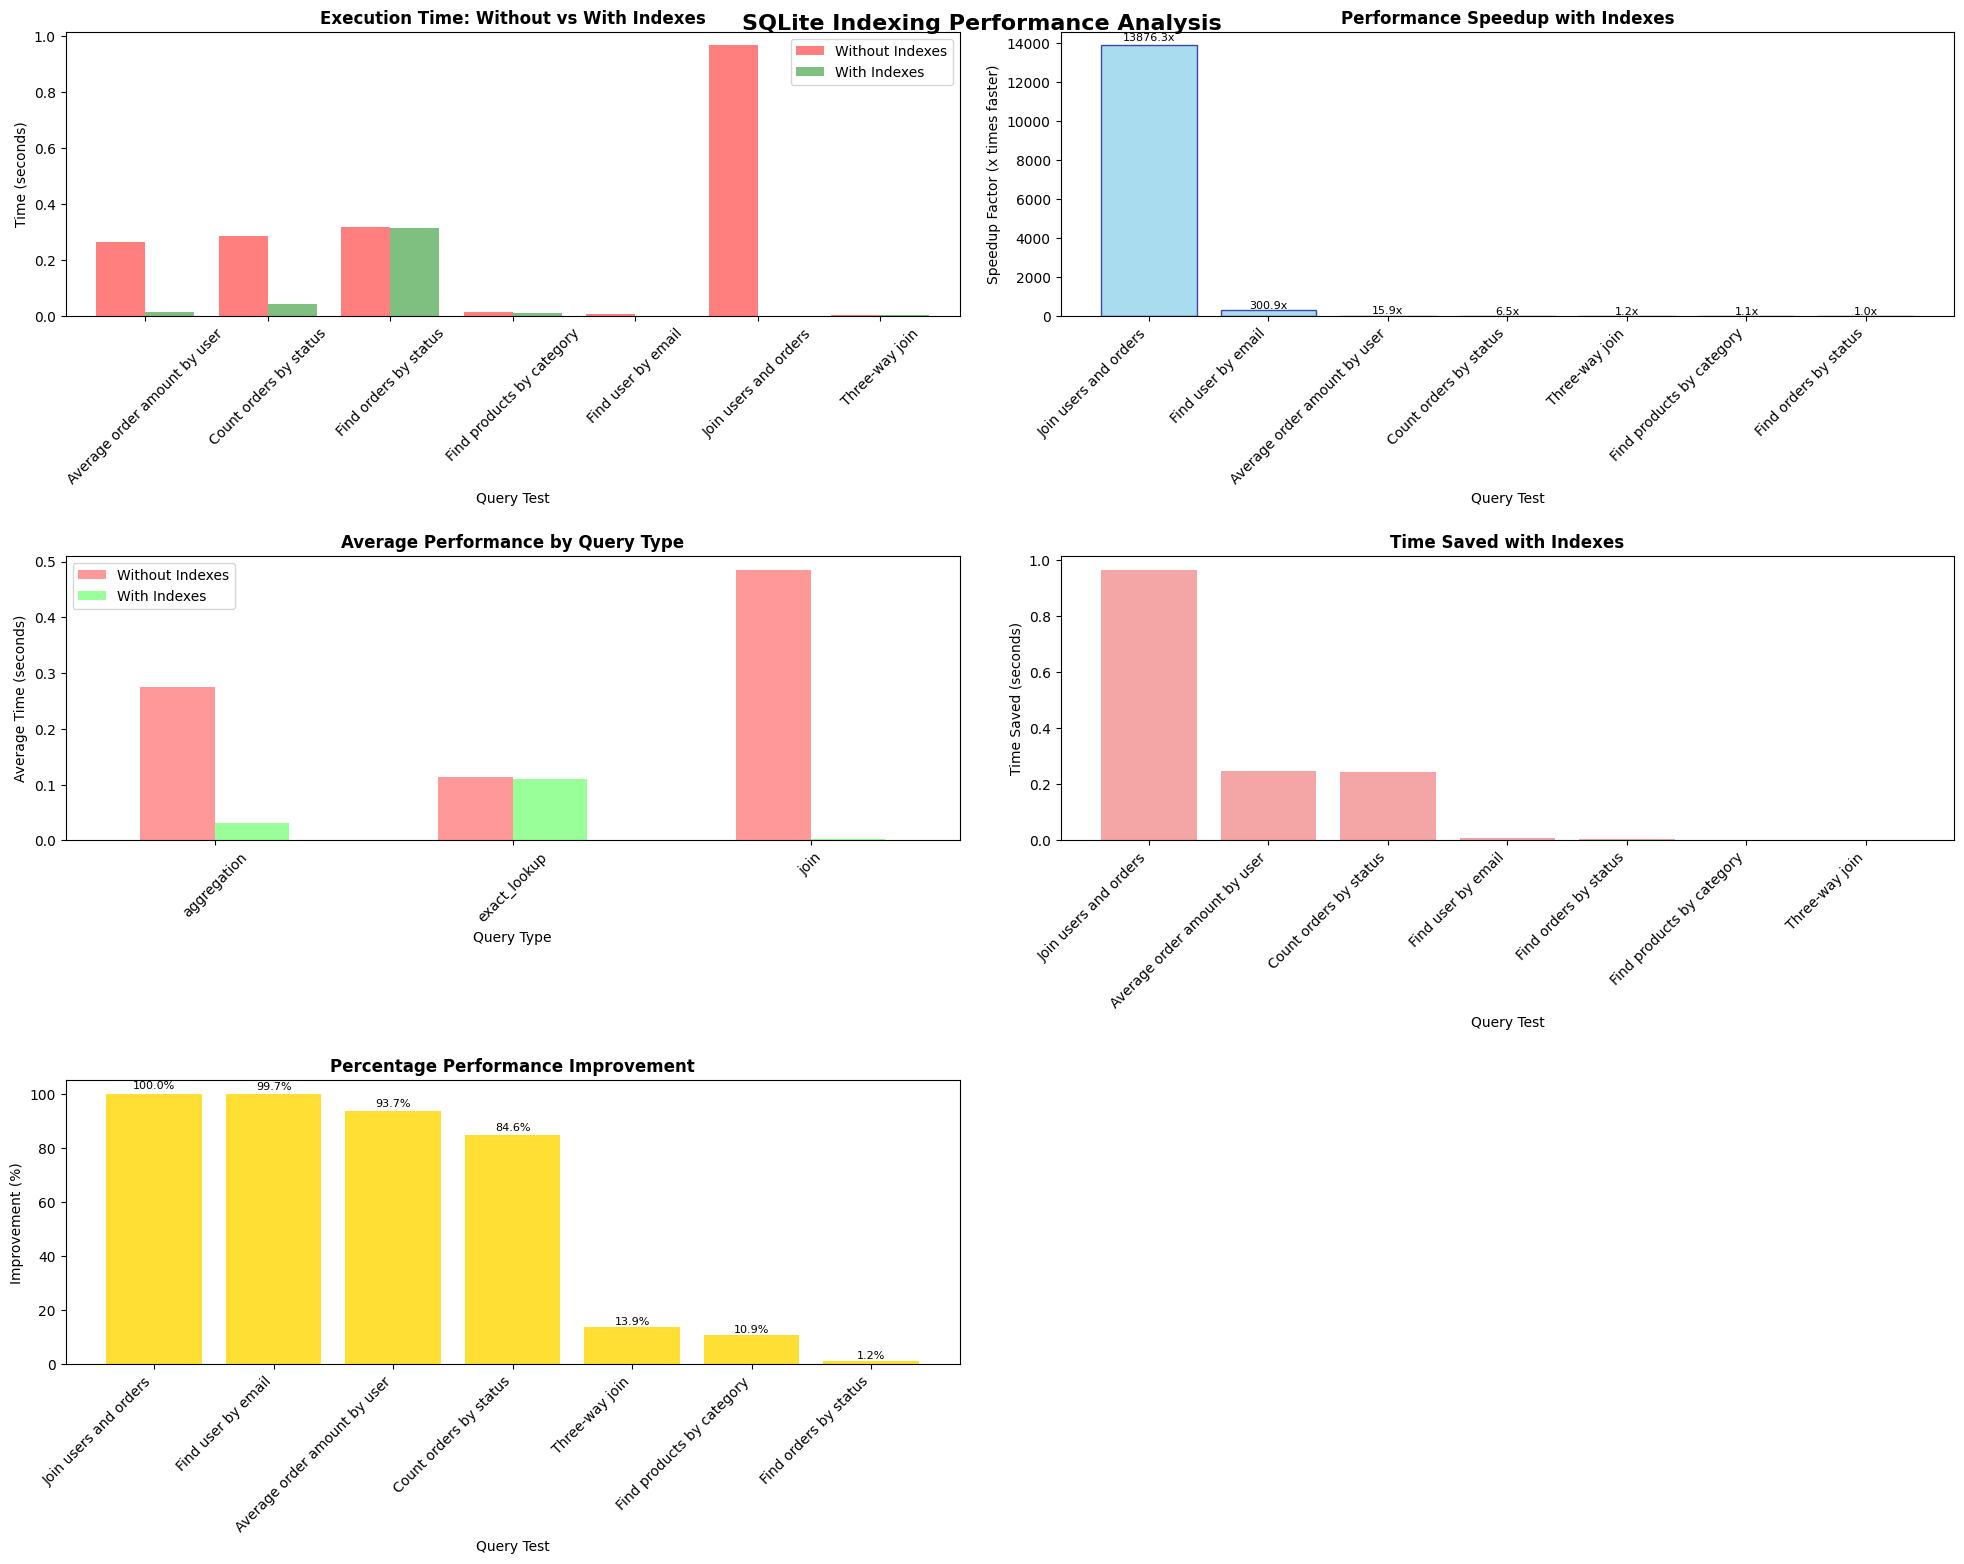

In [20]:
# Create comprehensive performance visualizations
def create_performance_visualizations(df: pd.DataFrame):
    """Create a comprehensive set of performance visualization charts."""
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("Set2")
    
    # Calculate speedup factors
    pivot_df = df.pivot_table(index='test_name', columns='indexed', values='avg_time_seconds')
    pivot_df['speedup_factor'] = pivot_df[False] / pivot_df[True]
    pivot_df['time_saved'] = pivot_df[False] - pivot_df[True]
    
    # Create subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Side-by-side comparison of execution times
    ax1 = plt.subplot(3, 2, 1)
    comparison_data = df.pivot(index='test_name', columns='indexed', values='avg_time_seconds')
    comparison_data.plot(kind='bar', ax=ax1, width=0.8, color=['#ff7f7f', '#7fbf7f'])
    ax1.set_title('Execution Time: Without vs With Indexes', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Query Test')
    ax1.set_ylabel('Time (seconds)')
    ax1.legend(['Without Indexes', 'With Indexes'])
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Speedup factor chart
    ax2 = plt.subplot(3, 2, 2)
    speedup_data = pivot_df['speedup_factor'].sort_values(ascending=False)
    bars = ax2.bar(range(len(speedup_data)), speedup_data.values, color='skyblue', edgecolor='navy', alpha=0.7)
    ax2.set_title('Performance Speedup with Indexes', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Query Test')
    ax2.set_ylabel('Speedup Factor (x times faster)')
    ax2.set_xticks(range(len(speedup_data)))
    ax2.set_xticklabels(speedup_data.index, rotation=45, ha='right')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.1f}x', ha='center', va='bottom', fontsize=8)
    
    # 3. Performance by query type
    ax3 = plt.subplot(3, 2, 3)
    query_type_perf = df.groupby(['query_type', 'indexed'])['avg_time_seconds'].mean().unstack()
    query_type_perf.plot(kind='bar', ax=ax3, color=['#ff9999', '#99ff99'])
    ax3.set_title('Average Performance by Query Type', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Query Type')
    ax3.set_ylabel('Average Time (seconds)')
    ax3.legend(['Without Indexes', 'With Indexes'])
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Time saved per query
    ax4 = plt.subplot(3, 2, 4)
    time_saved = pivot_df['time_saved'].sort_values(ascending=False)
    bars = ax4.bar(range(len(time_saved)), time_saved.values, color='lightcoral', alpha=0.7)
    ax4.set_title('Time Saved with Indexes', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Query Test')
    ax4.set_ylabel('Time Saved (seconds)')
    ax4.set_xticks(range(len(time_saved)))
    ax4.set_xticklabels(time_saved.index, rotation=45, ha='right')
    
    # 5. Percentage improvement
    ax5 = plt.subplot(3, 2, 5)
    percentage_improvement = ((pivot_df[False] - pivot_df[True]) / pivot_df[False] * 100).sort_values(ascending=False)
    bars = ax5.bar(range(len(percentage_improvement)), percentage_improvement.values, color='gold', alpha=0.8)
    ax5.set_title('Percentage Performance Improvement', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Query Test')
    ax5.set_ylabel('Improvement (%)')
    ax5.set_xticks(range(len(percentage_improvement)))
    ax5.set_xticklabels(percentage_improvement.index, rotation=45, ha='right')
    
    # Add percentage labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=8)
    
    
    plt.tight_layout(pad=2.0)
    plt.suptitle('SQLite Indexing Performance Analysis', fontsize=16, fontweight='bold', y=0.98)
    plt.show()
    
    return pivot_df

# Generate visualizations if we have results
if 'performance_results' in locals():
    analysis_data = create_performance_visualizations(performance_results)

    
else:
    print("No performance results found. Please run the performance test first.")